In [1]:
%pip install matplotlib pandas astropy regions


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.0.7_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
## IMPORT PACKAGES ##
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
#import scipy 
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
import os.path
from astropy import wcs
from astropy.wcs import WCS
from regions import Regions,PixCoord
from astropy.nddata import Cutout2D
from numpy.lib.recfunctions import append_fields
from matplotlib.colors import BoundaryNorm

In [3]:
## Galaxy Name & File Paths ##

### CHANGE THESE VALS ###
### INPUT PIXEL VALUES ###
crpix1,crpix2,x_len,y_len = 0, 0, 28, 22
## x,y coords of fiber 52 in TabHR file, and then highest x value and highest y value

galname = 'ngc3741'
filepath = './datasets/ngc3741data/' 
filepath_out = './results/ngc3741/test/'

## H alpha files ##
full_flux_file = filepath+galname+ '_panfit_6_single.fit'
spec_file = filepath+galname+'_join_cs.fits'
fxcor = filepath+galname+'_01fxcor.txt'
flag_file = filepath+galname+'_mask.txt'
reg_file = filepath+galname+'obs_ds9.reg'
sparse_pos_file = filepath+'tabHR_'+galname+'.sparse.dat'

## r band optical ##
r_image = filepath+galname+'r.fits'
Ha_image = filepath+galname+'ae.fits'

## HI Files ##
HIm0 = filepath+galname+'.lowmom.fits'
HIm1 = filepath+galname+'.lowvelfi.fits'
HIvdis = filepath+galname+'.lowvdisp.fits'

In [4]:
## PULLING INFORMATION FROM FILES ##

## General Files ## 
sparse_pos = np.genfromtxt(sparse_pos_file,usecols=(0,1,2),dtype=int,names=('id','x','y'))
#Getting the location information for the SparsePak fibers
flag = np.loadtxt(flag_file,dtype=int)
#Loading in the flag file, which fibers do not have an Halpha detection. If they don't have an Halpha detection,
# they will very very mostly likely not have [NII] or [SII] either. 
regions = Regions.read(reg_file, format='ds9')
#Loading in the regions file that tells us where each of the fibers are in WCS. 

## Halpha Selection ##
fluxes = pd.read_csv(full_flux_file,delim_whitespace=True)
HA_fluxes = fluxes.query('line_id == "Hac1"')
flux_file = filepath_out+galname+'sm_ha6563'
HA_fluxes.to_csv(flux_file,sep=' ',header=False)
fxcor_file = np.genfromtxt(fxcor,usecols = (12,13), skip_header = 15, names=('VHELIO','verr'))
rest_ha = 6562.8 * u.Angstrom
lam_to_vel_ha = u.doppler_optical(rest_ha)

## NII Selection ##
NII_fluxes1 = fluxes.query('line_id == "Hac2"')
NII_fluxes2 = fluxes.query('line_id == "Hac3"')
flux_fileN1 = filepath_out+galname+'sm_nii6548'
NII_fluxes1.to_csv(flux_fileN1,sep=' ',header=False)
flux_fileN2 = filepath_out+galname+'sm_nii6583'
NII_fluxes2.to_csv(flux_fileN2,sep=' ',header=False)
rest_NII1 = 6548.050 * u.Angstrom
lam_to_vel_N1 = u.doppler_optical(rest_NII1)
rest_NII2 = 6583.460 * u.Angstrom
lam_to_vel_N2 = u.doppler_optical(rest_NII2)

## SII Selection ##
SII_fluxes1 = fluxes.query('line_id == "Hac4"')
SII_fluxes2 = fluxes.query('line_id == "Hac5"')
flux_fileS1 = filepath_out+galname+'sm_sii6716'
SII_fluxes1.to_csv(flux_fileS1,sep=' ',header=False)
flux_fileS2 = filepath_out+galname+'sm_sii6731'
SII_fluxes2.to_csv(flux_fileS2,sep=' ',header=False)
rest_SII1 = 6716.440 * u.Angstrom
lam_to_vel_S1 = u.doppler_optical(rest_SII1)
rest_SII2 = 6730.810* u.Angstrom
lam_to_vel_S2 = u.doppler_optical(rest_SII2)

In [5]:
## H𝛼 Organized File ##

## From the pan fitting file that has the outputs from the gaussian fits, we want to pull out the flux (integral), 
## the center (recessional velocity), and the velocity dispersion measurement (full-width-half-max, fwhm)

PAN_Ha = np.genfromtxt(flux_file,usecols=(1,2,3,4,5,6,7,8),names=('chi','flux',
                        'flux_er','center','cen_err','fwhm','fwhm_er','spax_id')) 

In [6]:
## NII Organised File ##

## Nitrogren PAN files ##

## We want to take the PAN outputs for the nitrogen lines for both of the nitrogen lines. 
PAN_NII1 = np.genfromtxt(flux_fileN1,usecols=(1,2,3,4,5,6,7,8),names=('chi','flux','flux_er','center',
                                                                      'cen_err','fwhm','fwhm_er','spax_id'))
PAN_NII2 = np.genfromtxt(flux_fileN2,usecols=(1,2,3,4,5,6,7,8),names=('chi','flux','flux_er','center',
                                                                      'cen_err','fwhm','fwhm_er','spax_id'))

## This is calculating the total [NII] flux. We can just add together the fluxes from the files above
nii_tot_flux = []
for i in range(len(PAN_NII1['flux'])):
    nii_tot_flux.append(PAN_NII1['flux'][i]+PAN_NII2['flux'][i])
#Adding that to the PAN file
PAN_NII1 = append_fields(PAN_NII1, 'total_nii_flux',nii_tot_flux, usemask=False)

#We want to compare the total [NII] flux to the Halpha flux 
ratio_NII_Ha = []
for i in range(len(PAN_NII1['flux'])):
    ratio_NII_Ha.append(PAN_NII1['total_nii_flux'][i]/PAN_Ha['flux'][i])
#Adding that to PAN file    
PAN_NII = append_fields(PAN_NII1, 'nii_flux_ratio', ratio_NII_Ha, usemask=False)

#Converting the wavelength values to recessional velocities to compare to Halpha centers.
vel_nii1 = []
for i in range(len(PAN_NII1['center'])):
    vel_nii1.append((np.abs(6548.050 -PAN_NII1['center'][i])/6548.050)*3e5)

vel_nii2 = []
for i in range(len(PAN_NII2['center'])):
    vel_nii2.append((np.abs(6583.460  - PAN_NII2['center'][i])/6583.460)*3e5)
    
vel_ha = []
for i in range(len(PAN_Ha['center'])):
    vel_ha.append((np.abs(6562.819 - PAN_Ha['center'][i])/6562.819)*3e5)
# This conversion comes from the equation z=v/c where z = (Lambda_emitted-Lambda_observed/Lambda_emitted)
# These are in km/s 

# We are doing our not-very-robust masking by comparing the [NII] centers to the velocity centers. 
# Basically, in the same fiber/spectrum, the recessional velocity should be the same for both lines because the gas
# in a single location should be moving at the same speed. 
cendif_nii1ha = [] 
for i in range(len(vel_ha)):
    cendif_nii1ha.append(np.abs(vel_nii1[i]-vel_ha[i]))

cendif_nii2ha = []
for i in range(len(vel_nii2)):
    cendif_nii2ha.append(np.abs(vel_nii2[i]-vel_ha[i]))

PAN_NII = append_fields(PAN_NII, 'cendif_nii1ha', cendif_nii1ha, usemask=False)

PAN_NII = append_fields(PAN_NII, 'cendif_nii2ha', cendif_nii2ha, usemask=False)
#We're adding those to the PAN file above. We will call this value later and do a cut that takes out any 

In [7]:
## SII Organised File ##

##Sulfur PAN files
# These lines should be the same as the [NII] steps above, so I'm not going to make further comments here...

PAN_SII1 = np.genfromtxt(flux_fileS1,usecols=(1,2,3,4,5,6,7,8),names=('chi','flux','flux_er','center','cen_err','fwhm','fwhm_er','spax_id'))
PAN_SII2 = np.genfromtxt(flux_fileS2,usecols=(1,2,3,4,5,6,7,8),names=('chi','flux','flux_er','center','cen_err','fwhm','fwhm_er','spax_id'))

sii_tot_flux = []
for i in range(len(PAN_SII1['flux'])):
    sii_tot_flux.append(PAN_SII1['flux'][i]+PAN_SII2['flux'][i])

PAN_SII1 = append_fields(PAN_SII1, 'total_sii_flux',sii_tot_flux, usemask=False)
    
sii2sii_ratio = []
for i in range(len(PAN_SII1['flux'])):
    sii2sii_ratio.append(PAN_SII1['flux'][i]/PAN_SII2['flux'][i])

PAN_SII1 = append_fields(PAN_SII1, 'sii2sii_ratio',sii2sii_ratio, usemask=False)

ratio_SII_Ha = []
for i in range(len(PAN_SII1['flux'])):
    ratio_SII_Ha.append(PAN_SII1['total_sii_flux'][i]/PAN_Ha['flux'][i])
    
PAN_SII = append_fields(PAN_SII1, 'sii_flux_ratio', ratio_SII_Ha, usemask=False)

vel_sii1 = []
for i in range(len(PAN_SII1['center'])):
    vel_sii1.append((np.abs(6716.440-PAN_SII1['center'][i])/6716.440)*3e5)

vel_sii2 = []
for i in range(len(PAN_SII2['center'])):
    vel_sii2.append((np.abs(6730.810 - PAN_SII2['center'][i])/6730.810)*3e5)
    
vel_ha = []
for i in range(len(PAN_Ha['center'])):
    vel_ha.append((np.abs(6562.819 - PAN_Ha['center'][i])/6562.819)*3e5)

cendif_sii1ha = []
for i in range(len(vel_ha)):
    cendif_sii1ha.append(np.abs(vel_sii1[i]-vel_ha[i]))

cendif_sii2ha = []
for i in range(len(vel_sii2)):
    cendif_sii2ha.append(np.abs(vel_sii2[i]-vel_ha[i]))

PAN_SII = append_fields(PAN_SII, 'cendif_sii1ha', cendif_sii1ha, usemask=False)

PAN_SII = append_fields(PAN_SII, 'cendif_sii2ha', cendif_sii2ha, usemask=False)

In [8]:
## Making Arrays for Plotting ##

Ha_flux = []
Ha_fwhm = []
Ha_centers = []
NII_tot_flux = []
NII_Ha = []
NII_cen1 = []
NII_cen2 = []
SII_tot_flux = []
SII_Ha = []
SII_SII = []
SII_cen1 = []
SII_cen2 = []
fiber_ids = []

In [9]:
for j in range(len(PAN_Ha['spax_id'])):
    if flag[j]>0:
        # The PAN parameters are read incuding the flux, center, and velocity disperion along with certain errors
        y,x = int(sparse_pos['y'][j]),int(sparse_pos['x'][j])
        
        #Halpha Section
        flux_H = PAN_Ha['flux'][PAN_Ha['spax_id']==sparse_pos['id'][j]]
        center_lam_H = PAN_Ha['center'][PAN_Ha['spax_id']==sparse_pos['id'][j]] * u.Angstrom
        center_vel_H = center_lam_H.to(u.km/u.s, equivalencies = lam_to_vel_ha)
        chi_H = PAN_Ha['chi'][PAN_Ha['spax_id']==sparse_pos['id'][j]]
        fwhm_H = PAN_Ha['fwhm'][PAN_Ha['spax_id']==sparse_pos['id'][j]]* u.Angstrom
        fwhm_vel_H = abs((center_lam_H+.5*fwhm_H).to(u.km/u.s, equivalencies = lam_to_vel_ha)-(center_lam_H-.5*fwhm_H).to(u.km/u.s, 
                    equivalencies = lam_to_vel_ha))
        fx_center = fxcor_file['VHELIO'][j]*u.km/u.s
        fx_center_lam = fx_center.to(u.Angstrom, equivalencies = lam_to_vel_ha)
        fib_ids = PAN_Ha['spax_id'][PAN_Ha['spax_id']==sparse_pos['id'][j]]
        Ha_flux.append(flux_H)
        Ha_fwhm.append(fwhm_vel_H.value)
        Ha_centers.append(fx_center.value)
        fiber_ids.append(fib_ids)
        
        #NII Section
        NIItot = PAN_NII['total_nii_flux'][PAN_NII['spax_id']==sparse_pos['id'][j]]
        NIIHa = PAN_NII['nii_flux_ratio'][PAN_NII['spax_id']==sparse_pos['id'][j]]
        NIIcen1 = PAN_NII['cendif_nii1ha'][PAN_NII['spax_id']==sparse_pos['id'][j]]
        NIIcen2 = PAN_NII['cendif_nii2ha'][PAN_NII['spax_id']==sparse_pos['id'][j]]
        NII_tot_flux.append(NIItot)
        NII_Ha.append(NIIHa)
        NII_cen1.append(NIIcen1)
        NII_cen2.append(NIIcen2)
        
        #SII Section 
        SIItot = PAN_SII['total_sii_flux'][PAN_SII['spax_id']==sparse_pos['id'][j]]
        SIIHa = PAN_SII['sii_flux_ratio'][PAN_SII['spax_id']==sparse_pos['id'][j]]
        SIIcen1 = PAN_SII['cendif_sii1ha'][PAN_SII['spax_id']==sparse_pos['id'][j]]
        SIIcen2 = PAN_SII['cendif_sii2ha'][PAN_SII['spax_id']==sparse_pos['id'][j]]
        SIISII = PAN_SII['sii2sii_ratio'][PAN_SII['spax_id']==sparse_pos['id'][j]]
        SII_tot_flux.append(SIItot)
        SII_Ha.append(SIIHa)
        SII_SII.append(SIISII)
        SII_cen1.append(SIIcen1)
        SII_cen2.append(SIIcen2)

In [10]:
## Plotting Arrays ##

def inst_correct(arr,inst_corr):
    arr_inst_corr = np.empty_like(arr)
    for i in range(len(arr)):
        val = arr[i]
        if val>48.5:
                #print(val)
            arr_inst_corr[i] = np.sqrt(val**2-inst_corr**2)
                #print(arr_inst_corr[i][j])
        elif val>0:
            arr_inst_corr[i] = 0
        else:
            arr_inst_corr[i]=val
    return(arr_inst_corr)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '2009-04-20        ' to '2009-04-20T00:00:00.0''. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/p8/2qpn3ldx4s58gvbc0c41f6g80000gn/T/ipykernel_84338/3831944717.py:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(ids[j]-1)
/opt/homebrew/Cellar/jupyterlab/4.0.7_1/libexec/lib/python3.11/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)
/var/folders/p8/2qpn3ldx4s58gvbc0c41f6g80000gn/T/ipykernel_84338/3831944717.py:83: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ens

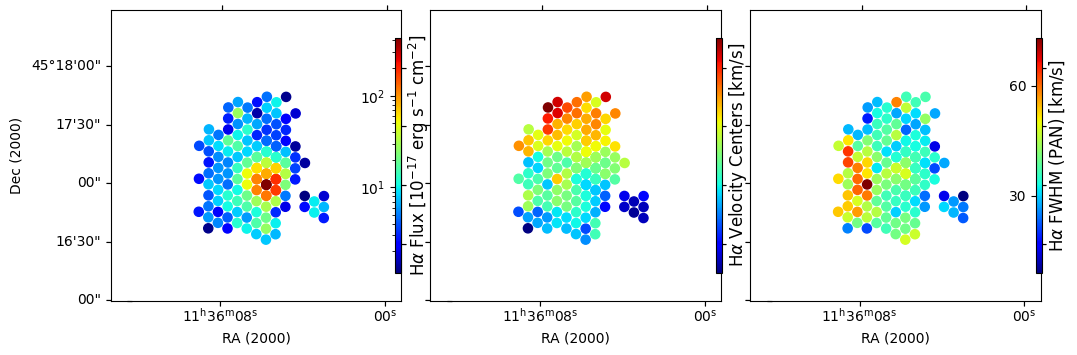

In [11]:
## Three Panel Plot of H𝛼 Moments ##

xmin_orig,xmax_orig,ymin_orig,ymax_orig = 975,1225,1050,1300

hdu1 = fits.open(r_image)[0]
wcs1_orig = WCS(hdu1.header)

# Make 2D cutout from 2 or 3 D data and save as tmp file
cutout_op = Cutout2D(hdu1.data, position=(xmin_orig,ymin_orig),size=(ymax_orig-ymin_orig,xmax_orig-xmin_orig),mode='partial', wcs=wcs1_orig)

hdu1.data = cutout_op.data
hdu1.header.update(cutout_op.wcs.to_header())
cutout_filename = filepath+'tmp_ir.fits'
hdu1.writeto(cutout_filename, overwrite=True)

stellarmap = filepath+'tmp_ir.fits'
hdu1 = fits.open(stellarmap)[0]
wcs1 = WCS(hdu1.header)

ids = np.array(fiber_ids)
fluxes = np.array(Ha_flux)
centers = np.array(Ha_centers)* u.km/u.s
fwhms = np.array(Ha_fwhm) * u.km/u.s # 1-D array of meas. values
vdisp_inst = inst_correct(fwhms.value,48.5)


##PLOTTING

##------------------------------------------------------------------------------

fig=plt.figure(figsize=(12,5))

ax1 = plt.subplot(131,projection=wcs1)
ax1.set_facecolor('white')
ax1.set_xlabel('RA (2000)')
ax1.set_ylabel('Dec (2000)')
ra_ax1 = ax1.coords['ra']
dec_ax1 = ax1.coords['dec']
cmapa = plt.get_cmap('jet')

# colors from mpl color tables can be referenced using single value floats between 0,1.
#We need to transform measurement values to this range, i.e., map colors to data values.

fluxes_log = np.log(fluxes)
fluxes_log = np.where(np.isnan(fluxes_log), 0, fluxes_log)

fluxes_cor = fluxes_log - np.nanmin(fluxes_log[fluxes>0])    # shift lowest data-value to zero

fluxes_cor = fluxes_cor/abs(np.max(fluxes_cor)) # normalize max to unity
#print(fluxes_cor)
# add each marker as an ARTIST (a pyplot circle), with its own position, size, fill option, and color.

alpimg = ax1.imshow(hdu1.data,origin='lower',cmap=plt.get_cmap('afmhot_r'),vmin = 10000,vmax=10000,
                    transform=ax1.get_transform(wcs1))

for j in range(len(ids)):
    i = int(ids[j]-1)
    circle = regions[i]
    halpha_circ= circle.to_pixel(wcs=wcs1)
    if fluxes[j]>0:
        halpha_circ.plot(ax=ax1,fill=True,color=cmapa(fluxes_cor[j]))       
        
ra_ax1.set_ticks(spacing=2* u.arcmin)

ax2 = plt.subplot(132,projection=wcs1)
ax2.set_facecolor('white')
ax2.set_xlabel('RA (2000)')
ra_ax2 = ax2.coords['ra']
dec_ax2 = ax2.coords['dec']
dec_ax2.set_ticklabel_visible(False)
cmapb = plt.get_cmap('jet')

#print(centers)
center_vel_cor = centers - np.min(centers[centers.value>0]) # shift lowest data-value to zero
center_vel_cor = center_vel_cor/abs(np.max(center_vel_cor.value[centers.value<380])) # normalize max to unity

alpimg = ax2.imshow(hdu1.data,origin='lower',cmap=plt.get_cmap('afmhot_r'),vmin = 10000,vmax=10000,
                  transform=ax2.get_transform(wcs1))

ra_ax2.set_ticks(spacing=2 * u.arcmin)

for j in range(len(ids)):
    i = int(ids[j]-1)
    circle = regions[i]
    halpha_circ= circle.to_pixel(wcs=wcs1)
    if fluxes[j]>0 and centers[j].value>0 and centers[j].value<500:
        halpha_circ.plot(ax=ax2,fill=True,color=cmapb(center_vel_cor[j])) 

ax3 = plt.subplot(133,projection=wcs1)
ax3.set_facecolor('white')
ax3.set_xlabel('RA (2000)')
ra_ax3 = ax3.coords['ra']
dec_ax3 = ax3.coords['dec']
dec_ax3.set_ticklabel_visible(False)
cmapc = plt.get_cmap('jet')

vdisp_inst_cor = vdisp_inst - np.nanmin(vdisp_inst[vdisp_inst>=0]) # shift lowest data-value to zero
vdisp_inst_cor = vdisp_inst_cor/abs(np.nanmax(vdisp_inst_cor[vdisp_inst<100])) # normalize max to unity

alpimg = ax3.imshow(hdu1.data,origin='lower',cmap=plt.get_cmap('afmhot_r'),vmin = 10000,vmax=10000,
                  transform=ax3.get_transform(wcs1))

ra_ax3.set_ticks(spacing=2 * u.arcmin)
for j in range(len(ids)):
    i = int(ids[j]-1)
    circle = regions[i]
    halpha_circ= circle.to_pixel(wcs=wcs1)
    if fluxes[j]>0 and vdisp_inst[j]>=0 and vdisp_inst[j]<250:
        halpha_circ.plot(ax=ax3,fill=True,color=cmapc(vdisp_inst_cor[j])) 

    
zmina,zmaxa = np.nanmin(fluxes[fluxes>0]),np.nanmax(fluxes)
#print(zmina,zmaxa)

# to connect a colorbar with the correct tick labels you need to use the 'norm' keyword
caxA = fig.add_axes([0.362,0.26,0.005,0.47])

norma = mpl.colors.LogNorm(vmin=zmina,vmax=zmaxa)
cbarA = mpl.colorbar.ColorbarBase(caxA,cmap=cmapa,norm=norma,ticks=[1,10,100,1000])
caxA.yaxis.tick_left()
cbarA.ax.set_ylabel(r'H$\alpha$ Flux [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$]',size=12)
caxA.tick_params(labelsize=10)

    
zminb,zmaxb = np.min(centers[centers.value>0]),np.max(centers[centers.value<400])
caxB = fig.add_axes([0.629,0.26,0.005,0.47])
normb = mpl.colors.Normalize(vmin=zminb.value,vmax=zmaxb.value)
cbarB = mpl.colorbar.ColorbarBase(caxB,cmap=cmapb,norm=normb,ticks=[0,5,15,30,150, 175, 200,300,320,340,360,380,400])
caxB.yaxis.tick_left()

cbarB.ax.set_ylabel(r'H$\alpha$ Velocity Centers [km/s]',size=12)

caxB.tick_params(labelsize=10)

zminc,zmaxc = np.nanmin(vdisp_inst[vdisp_inst>0]),np.nanmax(vdisp_inst[vdisp_inst<250])
caxC = fig.add_axes([0.896,0.26,0.005,0.47])
normc = mpl.colors.Normalize(vmin=zminc,vmax=zmaxc)
cbarC = mpl.colorbar.ColorbarBase(caxC,cmap=cmapc,norm=normc,ticks=[30,60,90,120,150])
caxC.yaxis.tick_left()
cbarC.ax.set_ylabel(r'H$\alpha$ FWHM (PAN) [km/s]',size=12)
caxC.tick_params(labelsize=10)

 
plt.subplots_adjust(wspace=0.1,hspace=0.001) #You need this at the end after your subplots but before show()

savefig_name = filepath_out+galname+'_Hamoments.png'

#You'll want to uncomment this when you're ready to save your figure!
#plt.savefig(savefig_name,format='png', dpi=300)

plt.show()

/var/folders/p8/2qpn3ldx4s58gvbc0c41f6g80000gn/T/ipykernel_84338/417885370.py:3: RuntimeWarning: invalid value encountered in log10
  NII_Ha_1 = np.array(np.log10(NII_Ha))
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '2009-04-22        ' to '2009-04-22T00:00:00.0''. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
/var/folders/p8/2qpn3ldx4s58gvbc0c41f6g80000gn/T/ipykernel_84338/417885370.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(ids[j]-1)
/opt/homebrew/Cellar/jupyterlab/4.0.7_1/libexec/lib/python3.11/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


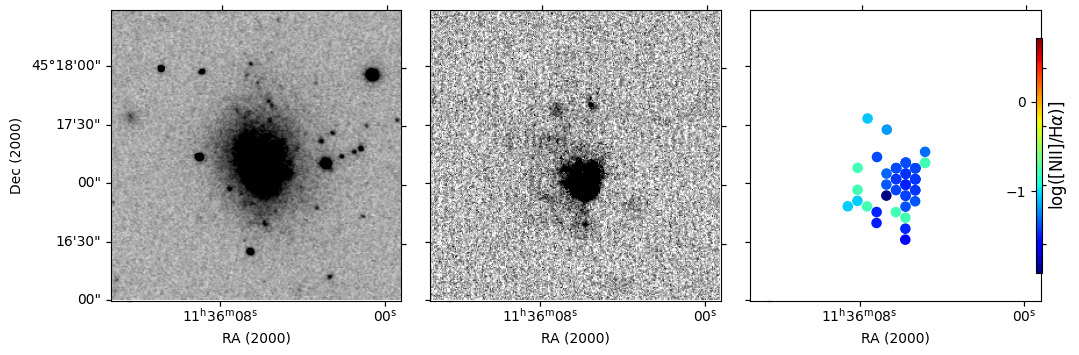

In [12]:
## Three Panel Plot of Optical, H𝛼, and NII ##

NII_Ha_1 = np.array(np.log10(NII_Ha))
NII_cen1a = np.array(NII_cen1)
NII_cen2b = np.array(NII_cen2)

fluxrat = NII_Ha_1
fluxrat = np.where(np.isnan(NII_Ha_1), 0, fluxrat)
fluxrat_cor = fluxrat - np.nanmin(fluxrat[fluxrat>-3.0])    # shift lowest data-value to zero
fluxrat_cor = fluxrat_cor/abs(np.max(fluxrat_cor[fluxrat<6]))
##------------------------------------------------------------------------------

fig=plt.figure(figsize=(12,5))

ax1 = plt.subplot(131,projection=wcs1)
ax1.set_facecolor('white')
ax1.set_xlabel('RA (2000)')
ax1.set_ylabel('Dec (2000)')
ra_ax1 = ax1.coords['ra']
dec_ax1 = ax1.coords['dec']
cmapa = plt.get_cmap('binary')

# colors from mpl color tables can be referenced using single value floats between 0,1.
#We need to transform measurement values to this range, i.e., map colors to data values.
# add each marker as an ARTIST (a pyplot circle), with its own position, size, fill option, and color.

alpimg = ax1.imshow(hdu1.data,origin='lower',cmap=plt.get_cmap('binary'),vmin = -50,vmax=100,
                    transform=ax1.get_transform(wcs1))
       
        
ra_ax1.set_ticks(spacing=2* u.arcmin)

hdu2 = fits.open(Ha_image)[0]
wcs2_orig = WCS(hdu2.header)

# Make 2D cutout from 2 or 3 D data and save as tmp file
cutout_op = Cutout2D(hdu2.data, position=(xmin_orig,ymin_orig),size=(ymax_orig-ymin_orig,xmax_orig-xmin_orig),mode='partial', wcs=wcs2_orig)

hdu2.data = cutout_op.data
hdu2.header.update(cutout_op.wcs.to_header())
cutout_filename = filepath_out+'tmp_ae.fits'
hdu2.writeto(cutout_filename, overwrite=True)

Hamap = filepath_out+'tmp_ae.fits'
hdu2 = fits.open(Hamap)[0]
wcs2 = WCS(hdu2.header)


ax2 = plt.subplot(132,projection=wcs1)
ax2.set_facecolor('white')
ax2.set_xlabel('RA (2000)')
ra_ax2 = ax2.coords['ra']
dec_ax2 = ax2.coords['dec']
dec_ax2.set_ticklabel_visible(False)
cmapb = plt.get_cmap('binary')


alpimg = ax2.imshow(hdu2.data,origin='lower',cmap=plt.get_cmap('binary'),vmin =-10,vmax=25,
                  transform=ax2.get_transform(wcs2))

ra_ax2.set_ticks(spacing=2 * u.arcmin)


ax4 = plt.subplot(133,projection=wcs1)
ax4.set_facecolor('white')
ax4.set_xlabel('RA (2000)')
ra_ax4 = ax4.coords['ra']
dec_ax4 = ax4.coords['dec']
dec_ax4.set_ticklabel_visible(False)
cmapd = plt.get_cmap('jet')

alpimg = ax4.imshow(hdu1.data,origin='lower',cmap=plt.get_cmap('afmhot_r'),vmin = 10000,vmax=10000,
                  transform=ax4.get_transform(wcs1))

ra_ax4.set_ticks(spacing=2 * u.arcmin)
for j in range(len(ids)):
    i = int(ids[j]-1)
    circle = regions[i]
    halpha_circ= circle.to_pixel(wcs=wcs1)
    if NII_cen1a[j]<20 and NII_cen2b[j]<20:
        halpha_circ.plot(ax=ax4,fill=True,color=cmapd(fluxrat_cor[j]))  


zmind,zmaxd = np.nanmin(NII_Ha_1[NII_Ha_1>-2.5]),np.nanmax(NII_Ha_1[NII_Ha_1<2.0])

# to connect a colorbar with the correct tick labels you need to use the 'norm' keyword
caxD = fig.add_axes([0.896,0.26,0.005,0.47])
normd = mpl.colors.Normalize(vmin=zmind,vmax=zmaxd)
cbarD = mpl.colorbar.ColorbarBase(caxD,cmap=cmapd,norm=normd,ticks=[-3,-2,-1,0,1,2])
caxD.yaxis.tick_left()
cbarD.ax.set_ylabel(r'log([NII]/H$\alpha$)]',size=12)
caxD.tick_params(labelsize=10)
 
plt.subplots_adjust(wspace=0.1,hspace=0.001) #You need this at the end after your subplots but before show()

savefig_name = filepath_out+galname+'_NIIHa.png'

#plt.savefig(savefig_name,format='png', dpi=300)

plt.show()

/var/folders/p8/2qpn3ldx4s58gvbc0c41f6g80000gn/T/ipykernel_84338/1591994237.py:3: RuntimeWarning: invalid value encountered in log10
  SII_Ha_1 = np.array(np.log10(SII_Ha))
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '2009-04-22        ' to '2009-04-22T00:00:00.0''. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


-2.2556469937717663
3.354638759128223


/var/folders/p8/2qpn3ldx4s58gvbc0c41f6g80000gn/T/ipykernel_84338/1591994237.py:79: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  i = int(ids[j]-1)
/opt/homebrew/Cellar/jupyterlab/4.0.7_1/libexec/lib/python3.11/site-packages/regions/shapes/circle.py:161: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Circle(xy=xy, radius=radius, **mpl_kwargs)


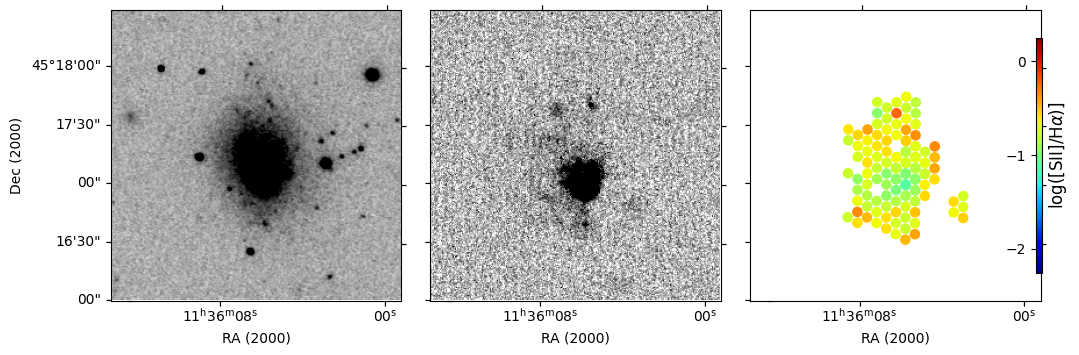

In [13]:
## Making Optical, H𝛼, and SII Plots ##

SII_Ha_1 = np.array(np.log10(SII_Ha))
SII_cen1a = np.array(SII_cen1)
SII_cen2b = np.array(SII_cen2)
print(np.nanmin(SII_Ha_1))
print(np.nanmax(SII_Ha_1))

fluxrat = SII_Ha_1
fluxrat = np.where(np.isnan(SII_Ha_1), 0, fluxrat)
fluxrat_cor = fluxrat - np.nanmin(fluxrat[fluxrat>-2.5])    # shift lowest data-value to zero
fluxrat_cor = fluxrat_cor/abs(np.max(fluxrat_cor[fluxrat<3]))
##------------------------------------------------------------------------------

fig=plt.figure(figsize=(12,5))

ax1 = plt.subplot(131,projection=wcs1)
ax1.set_facecolor('white')
ax1.set_xlabel('RA (2000)')
ax1.set_ylabel('Dec (2000)')
ra_ax1 = ax1.coords['ra']
dec_ax1 = ax1.coords['dec']
cmapa = plt.get_cmap('binary')

# colors from mpl color tables can be referenced using single value floats between 0,1.
#We need to transform measurement values to this range, i.e., map colors to data values.
# add each marker as an ARTIST (a pyplot circle), with its own position, size, fill option, and color.

alpimg = ax1.imshow(hdu1.data,origin='lower',cmap=plt.get_cmap('binary'),vmin = -50,vmax=100,
                    transform=ax1.get_transform(wcs1))
       
        
ra_ax1.set_ticks(spacing=2* u.arcmin)

hdu2 = fits.open(Ha_image)[0]
wcs2_orig = WCS(hdu2.header)

# Make 2D cutout from 2 or 3 D data and save as tmp file
cutout_op = Cutout2D(hdu2.data, position=(xmin_orig,ymin_orig),size=(ymax_orig-ymin_orig,xmax_orig-xmin_orig),mode='partial', wcs=wcs2_orig)

hdu2.data = cutout_op.data
hdu2.header.update(cutout_op.wcs.to_header())
cutout_filename = filepath_out+'tmp_ae.fits'
hdu2.writeto(cutout_filename, overwrite=True)

Hamap = filepath_out+'tmp_ae.fits'
hdu2 = fits.open(Hamap)[0]
wcs2 = WCS(hdu2.header)


ax2 = plt.subplot(132,projection=wcs1)
ax2.set_facecolor('white')
ax2.set_xlabel('RA (2000)')
ra_ax2 = ax2.coords['ra']
dec_ax2 = ax2.coords['dec']
dec_ax2.set_ticklabel_visible(False)
cmapb = plt.get_cmap('binary')


alpimg = ax2.imshow(hdu2.data,origin='lower',cmap=plt.get_cmap('binary'),vmin =-10,vmax=25,
                  transform=ax2.get_transform(wcs2))

ra_ax2.set_ticks(spacing=2 * u.arcmin)


ax4 = plt.subplot(133,projection=wcs1)
ax4.set_facecolor('white')
ax4.set_xlabel('RA (2000)')
ra_ax4 = ax4.coords['ra']
dec_ax4 = ax4.coords['dec']
dec_ax4.set_ticklabel_visible(False)
cmapd = plt.get_cmap('jet')

alpimg = ax4.imshow(hdu1.data,origin='lower',cmap=plt.get_cmap('afmhot_r'),vmin = 10000,vmax=10000,
                  transform=ax4.get_transform(wcs1))

ra_ax4.set_ticks(spacing=2 * u.arcmin)
for j in range(len(ids)):
    i = int(ids[j]-1)
    circle = regions[i]
    halpha_circ= circle.to_pixel(wcs=wcs1)
    if SII_cen1a[j]<20 and SII_cen2b[j]<20:
        halpha_circ.plot(ax=ax4,fill=True,color=cmapd(fluxrat_cor[j]))  


zmind,zmaxd = np.nanmin(SII_Ha_1[SII_Ha_1>-2.5]),np.nanmax(SII_Ha_1[SII_Ha_1<2.0])

caxD = fig.add_axes([0.896,0.26,0.005,0.47])
normd = mpl.colors.Normalize(vmin=zmind,vmax=zmaxd)
cbarD = mpl.colorbar.ColorbarBase(caxD,cmap=cmapd,norm=normd,ticks=[-3,-2,-1,0,1,2])
caxD.yaxis.tick_left()
cbarD.ax.set_ylabel(r'log([SII]/H$\alpha$)]',size=12)
caxD.tick_params(labelsize=10)
 
plt.subplots_adjust(wspace=0.1,hspace=0.001) #You need this at the end after your subplots but before show()

savefig_name = filepath_out+galname+'_SIIHa.png'

#plt.savefig(savefig_name,format='png', dpi=300)

plt.show()